# ITALY - FINAL MODEL

In [1]:
import pandas as pd
import numpy as np
from numpy import concatenate
import itertools
import re
from math import sqrt
import os
import warnings
import datetime

import matplotlib.pyplot as plt
from matplotlib import pyplot
import matplotlib

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

E:\Ananconda_Installation\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
E:\Ananconda_Installation\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
E:\Ananconda_Installation\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


## 1. Reading Data

In [2]:
df_unemployment=pd.read_csv(r'E:\Jupyter notebooks\hackathon23_somnolence\data\raw\third_party\oecd\Unemployment_Rate_OECD.csv')
df_unemployment.head()

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value,Flag Codes
0,AUS,HUR,TOT,PC_LF,A,1967,1.875,NaN
1,AUS,HUR,TOT,PC_LF,A,1968,1.850,NaN
2,AUS,HUR,TOT,PC_LF,A,1969,1.800,NaN
3,AUS,HUR,TOT,PC_LF,A,1970,1.625,NaN
4,AUS,HUR,TOT,PC_LF,A,1971,1.925,NaN


In [3]:
df_unemployment['LOCATION'].unique()

array(['AUS', 'AUT', 'BEL', 'CAN', 'CZE', 'DNK', 'FIN', 'FRA', 'DEU',
       'GRC', 'HUN', 'ISL', 'IRL', 'ITA', 'JPN', 'KOR', 'LUX', 'MEX',
       'NLD', 'NZL', 'NOR', 'POL', 'PRT', 'SVK', 'ESP', 'SWE', 'CHE',
       'TUR', 'GBR', 'USA', 'CHL', 'EST', 'ISR', 'SVN', 'OECD', 'G-7',
       'EA19', 'LVA', 'LTU', 'COL', 'EU27_2020', 'CRI'], dtype=object)

In [4]:
#Location variable to control country
location='ITA'

In [5]:
df_unemployment=df_unemployment[(df_unemployment['LOCATION']==location)&(df_unemployment['SUBJECT']=='TOT')].copy()
df_unemployment_monthly=df_unemployment[df_unemployment['TIME'].str.contains(r'\d{4}\-\d{2}',regex=True)]
df_unemployment_monthly['TIME']=pd.to_datetime(df_unemployment_monthly['TIME'],format='%Y-%m')
df_unemployment_monthly=df_unemployment_monthly.set_index('TIME')

C:\Users\PRADEEP SINGH\AppData\Local\Temp\ipykernel_7228\495960325.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unemployment_monthly['TIME']=pd.to_datetime(df_unemployment_monthly['TIME'],format='%Y-%m')


In [6]:
df_unemployment_monthly

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,Value,Flag Codes
TIME,,,,,,,
1983-01-01,ITA,HUR,TOT,PC_LF,M,6.9,P
1983-02-01,ITA,HUR,TOT,PC_LF,M,7.1,P
1983-03-01,ITA,HUR,TOT,PC_LF,M,7.2,P
1983-04-01,ITA,HUR,TOT,PC_LF,M,7.2,P
1983-05-01,ITA,HUR,TOT,PC_LF,M,7.3,P
...,...,...,...,...,...,...,...
2022-10-01,ITA,HUR,TOT,PC_LF,M,7.9,NaN
2022-11-01,ITA,HUR,TOT,PC_LF,M,7.9,NaN
2022-12-01,ITA,HUR,TOT,PC_LF,M,7.9,NaN


## 2. Univariate Time Series ARIMA

https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b

### 2.1. EDA

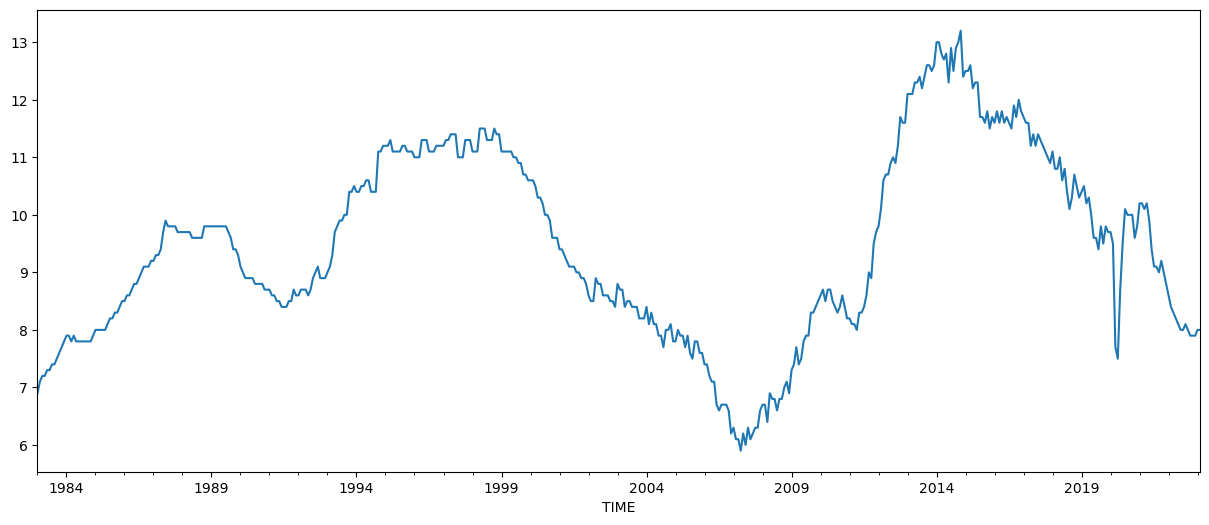

In [7]:
df_unemployment_monthly['Value'].plot(figsize=(15, 6))
plt.show()

#### 2.1.1. Decomposing Time Series to Trend, Seasonality and Residuals

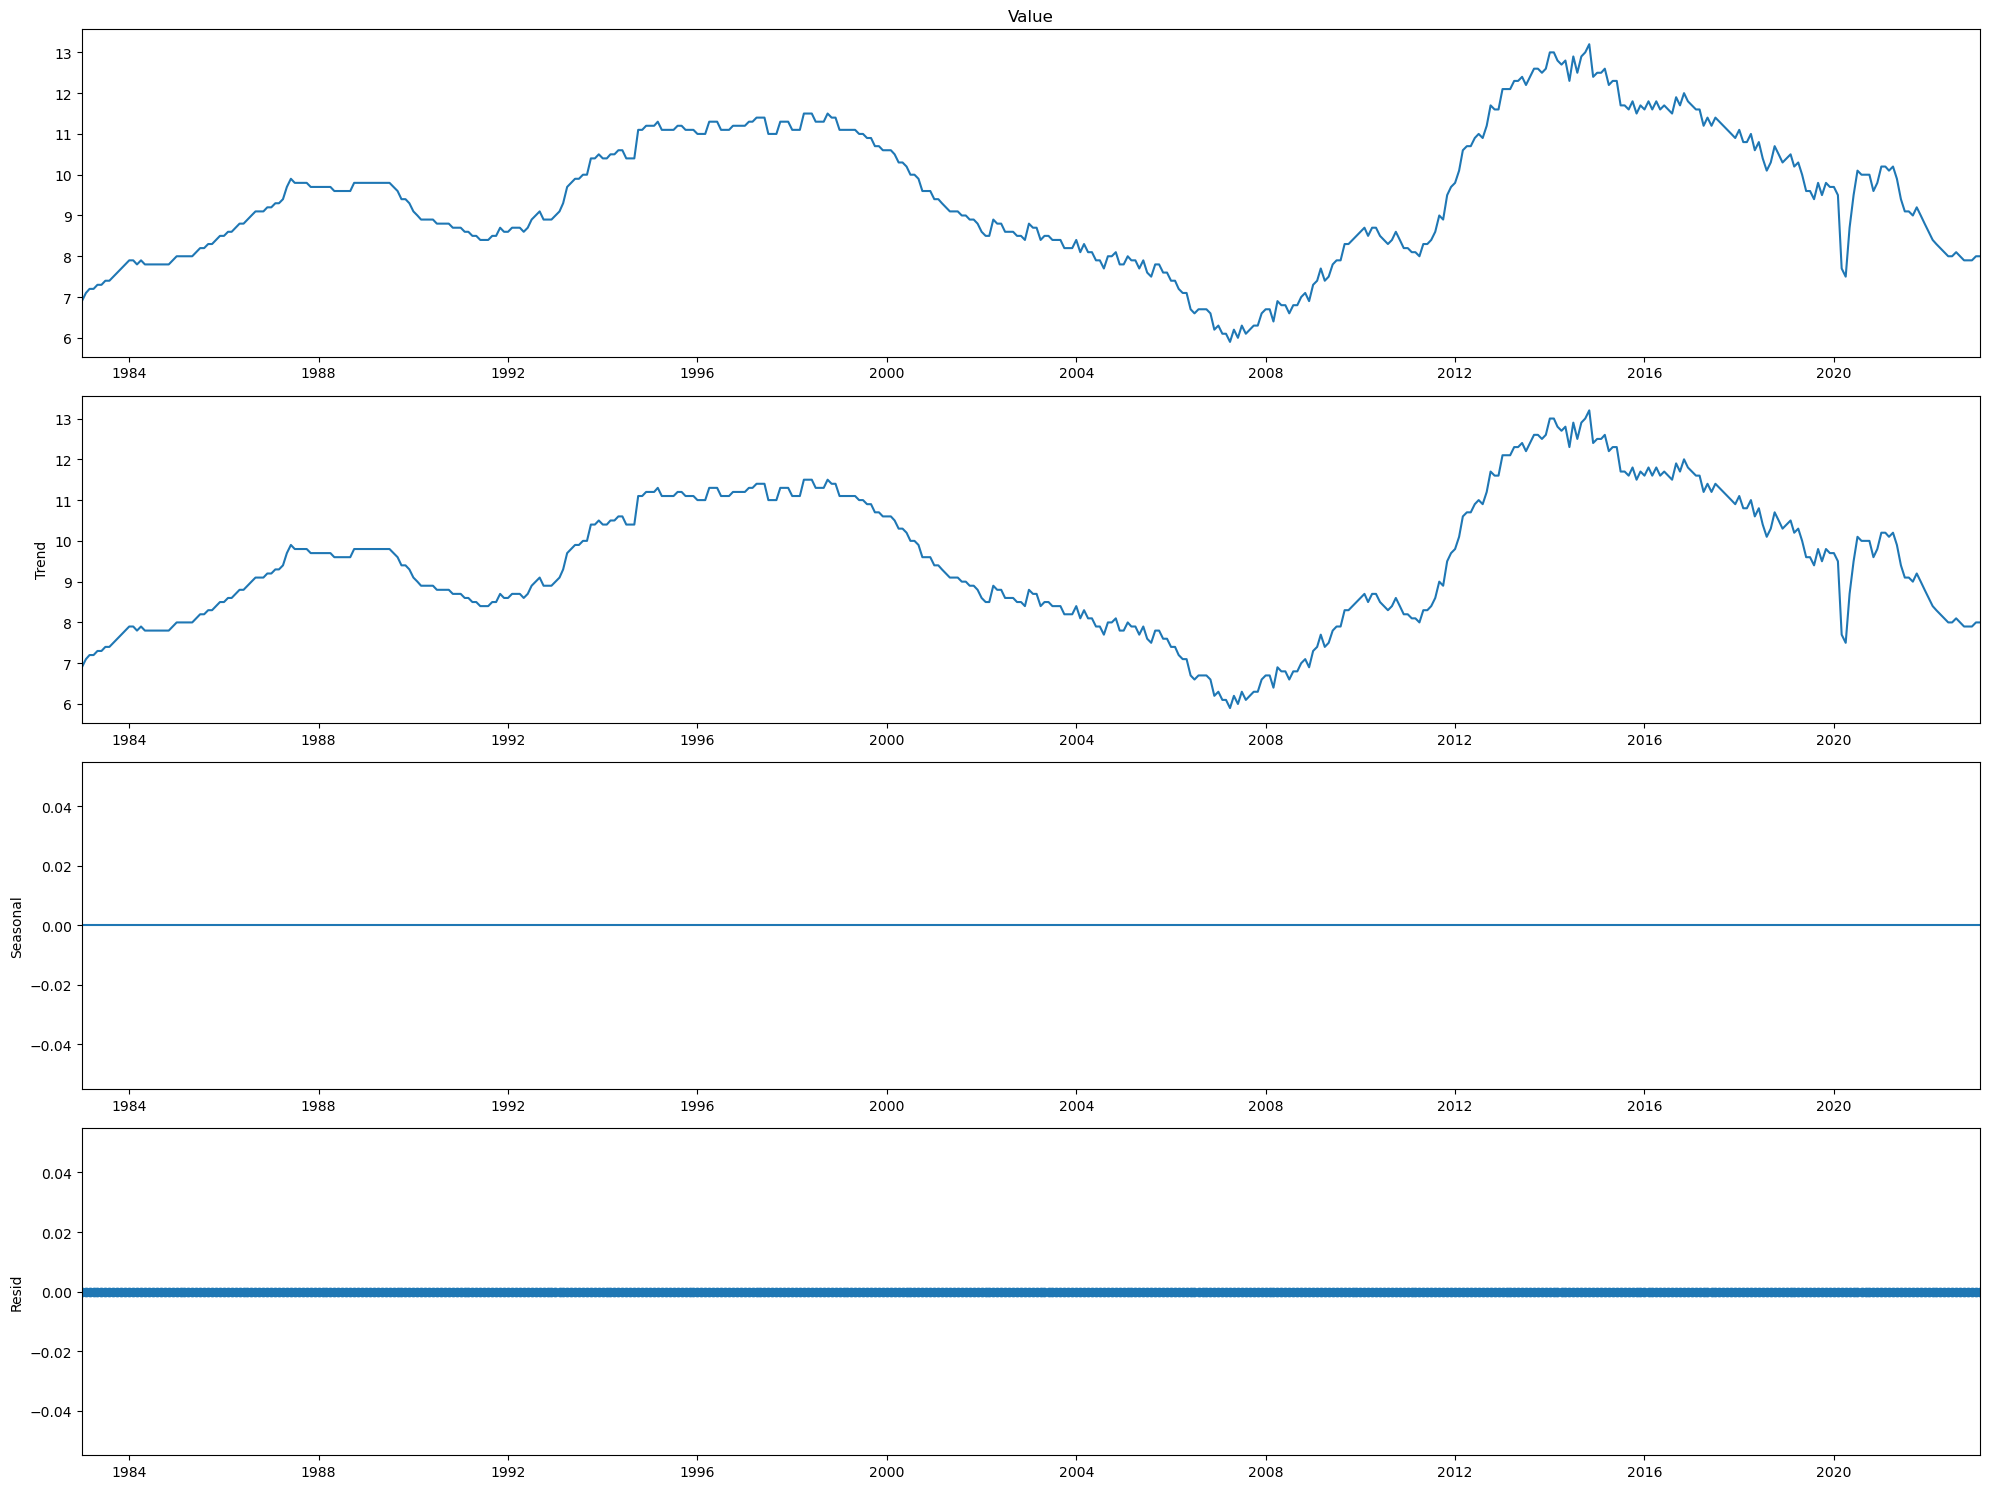

In [8]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 15
decomposition = sm.tsa.seasonal_decompose(df_unemployment_monthly['Value'], model='additive',period=1)
fig = decomposition.plot()
plt.show()

#### 2.1.2. Checking Stationarity

In [9]:
adfuller_result = adfuller(df_unemployment_monthly['Value'].values, autolag='AIC')
print('ADF statistics: ', adfuller_result[0])
print('p-value: ', adfuller_result[1])
if adfuller_result[1] >= 0.05:
    print('------Non-stationary time series. Checking first difference------------')
    df_unemployment_monthly_transformed = df_unemployment_monthly['Value'].diff().dropna()
    adfuller_result = adfuller(df_unemployment_monthly_transformed.values, autolag='AIC')
    print('ADF statistics at first difference: ', adfuller_result[0])
    print('p-value: ', adfuller_result[1])
else:
    print('Stationary time series')

ADF statistics:  -2.1979498847732852
p-value:  0.20699037169970147
------Non-stationary time series. Checking first difference------------
ADF statistics at first difference:  -4.685211079486459
p-value:  8.970394513329525e-05


### 2.2. Modelling 

In [10]:
train_limit=df_unemployment_monthly.shape[0]-12

Y_train=df_unemployment_monthly.iloc[0:train_limit,5]
Y_validation=df_unemployment_monthly.iloc[train_limit:,5]
Y_full=df_unemployment_monthly.iloc[:,5]

#### 2.2.1. Determining optimum p,d,q values

In [11]:
%%time

def evaluate_sarimax_model(Y_train, Y_validation, order):
    mod = sm.tsa.statespace.SARIMAX(Y_train,
                                    order=order,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
    results = mod.fit()
    
    predictions={}
    for date in Y_validation.index:
        pred=results.get_prediction(pd.to_datetime(date))
        predictions[date]=pred.predicted_mean[0]
        
    y_forecasted = np.array(list(predictions.values()))
    y_truth = Y_validation.values
    mse = ((y_forecasted - y_truth) ** 2).mean()
    return sqrt(mse)

def evaluate_arima_model(Y_train, Y_validation, order):
    mod = ARIMA(Y_train,
                order=order)
    results = mod.fit()
    
    predictions={}
    for date in Y_validation.index:
        pred=results.get_prediction(pd.to_datetime(date))
        predictions[date]=pred.predicted_mean[0]
        
    y_forecasted = np.array(list(predictions.values()))
    y_truth = Y_validation.values
    mse = ((y_forecasted - y_truth) ** 2).mean()
    return sqrt(mse)

def evaluate_models(dataset, validation_dataset,p_values,d_values,q_values):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                rmse = evaluate_arima_model(dataset, validation_dataset, order)
                if rmse < best_score:
                    best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%s' % (order,rmse))

    print('Best ARIMA%s RMSE= %s' % (best_cfg, best_score))
    return best_cfg
    
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
best_cfg=evaluate_models(Y_train, Y_validation, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=1.4802965403046224
ARIMA(0, 0, 1) RMSE=1.452849533610304
ARIMA(0, 0, 2) RMSE=1.4120198228887173
ARIMA(0, 1, 0) RMSE=0.38514066694304505
ARIMA(0, 1, 2) RMSE=0.3689457416039933
ARIMA(0, 2, 1) RMSE=0.1253517858851782
ARIMA(8, 0, 1) RMSE=0.12412939453396732
ARIMA(8, 1, 1) RMSE=0.1207070292678324
ARIMA(10, 0, 2) RMSE=0.11821519366046244
ARIMA(10, 1, 0) RMSE=0.1165575034341106
ARIMA(10, 1, 2) RMSE=0.10747075150064135
Best ARIMA(10, 1, 2) RMSE= 0.10747075150064135
Wall time: 1min 44s


In [12]:
# stepwise_fit = auto_arima(Y_train, start_p=0,max_p=10, start_d=2, max_d=3, start_q =0, max_q=3,trace=True,suppress_warnings=True)
# stepwise_fit.summary()

#### 2.2.2. Fitting Model

In [13]:
mod = ARIMA(Y_train,order=best_cfg)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5571      0.160      3.489      0.000       0.244       0.870
ar.L2         -0.7629      0.140     -5.461      0.000      -1.037      -0.489
ar.L3         -0.1528      0.057     -2.661      0.008      -0.265      -0.040
ar.L4          0.1501      0.051      2.926      0.003       0.050       0.251
ar.L5         -0.1266      0.054     -2.325      0.020      -0.233      -0.020
ar.L6          0.1296      0.052      2.474      0.013       0.027       0.232
ar.L7          0.1123      0.059      1.916      0.055      -0.003       0.227
ar.L8          0.1124      0.061      1.835      0.066      -0.008       0.232
ar.L9          0.0831      0.043      1.918      0.055      -0.002       0.168
ar.L10         0.1694      0.054      3.136      0.002       0.064       0.275
ma.L1         -0.5952      0.160     -3.726      0.0

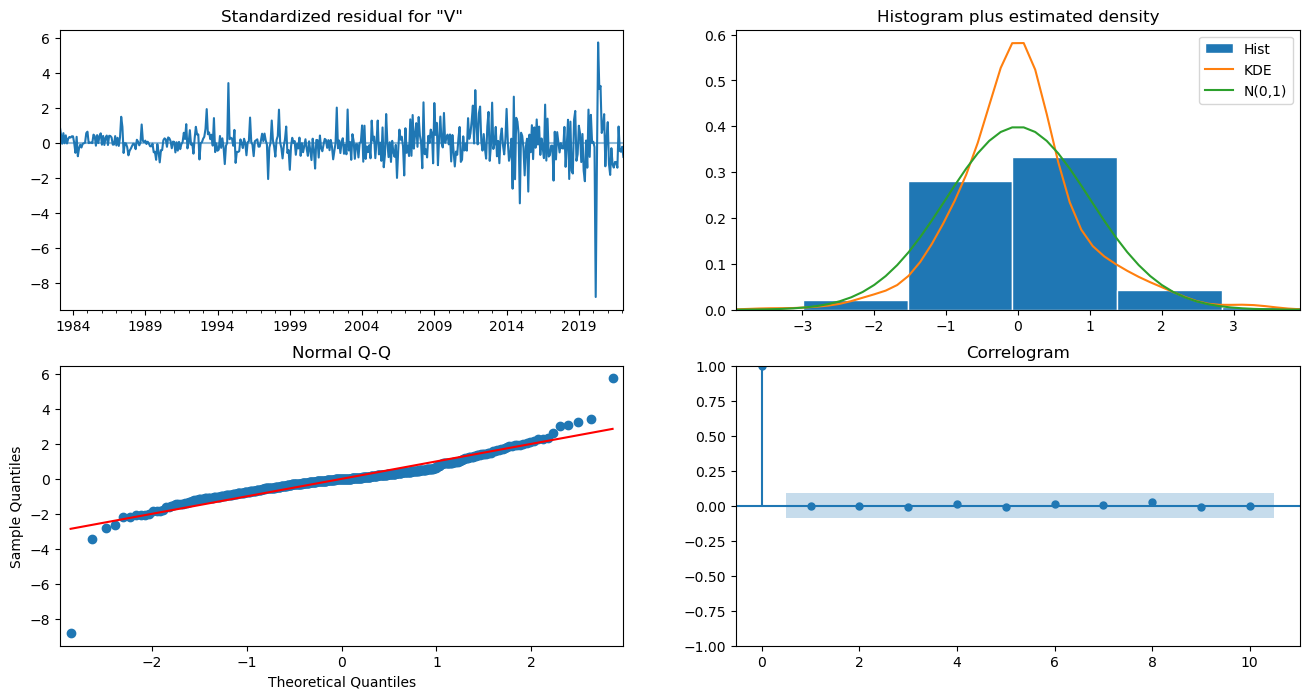

In [14]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

#### 2.2.3. Model Results

In [15]:
predictions={}
for date in Y_validation.index:
    pred=results.get_prediction(pd.to_datetime(date))
    predictions[date]=pred.predicted_mean[0]

In [16]:
y_forecasted = np.array(list(predictions.values()))
y_truth = Y_validation.values
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Root Mean Squared Error of our forecasts is {}'.format(sqrt(mse)))

The Root Mean Squared Error of our forecasts is 0.10747075150064135


#### 2.2.4. Training on Full Data and Predicting

In [17]:
mod_full_data = ARIMA(Y_full,order=best_cfg)
results_full_data = mod_full_data.fit()
print(results_full_data.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7033      0.074      9.528      0.000       0.559       0.848
ar.L2         -0.8834      0.071    -12.376      0.000      -1.023      -0.744
ar.L3         -0.1449      0.062     -2.337      0.019      -0.266      -0.023
ar.L4          0.1627      0.052      3.147      0.002       0.061       0.264
ar.L5         -0.1456      0.053     -2.734      0.006      -0.250      -0.041
ar.L6          0.1380      0.053      2.610      0.009       0.034       0.242
ar.L7          0.1057      0.060      1.752      0.080      -0.013       0.224
ar.L8          0.0815      0.062      1.323      0.186      -0.039       0.202
ar.L9          0.1015      0.046      2.225      0.026       0.012       0.191
ar.L10         0.1416      0.050      2.819      0.005       0.043       0.240
ma.L1         -0.7368      0.059    -12.487      0.0

In [18]:
preds_df = (results_full_data
            .get_prediction(start='2023-01-01', end='2023-05-01')
            .summary_frame(alpha=0.05)
)

preds_df

Value,mean,mean_se,mean_ci_lower,mean_ci_upper
2023-01-01,7.968022,0.198987,7.578015,8.358029
2023-02-01,7.979103,0.198987,7.589096,8.369110
2023-03-01,7.913102,0.198987,7.523095,8.303109
2023-04-01,7.826596,0.276729,7.284218,8.368975
2023-05-01,7.850224,0.339910,7.184013,8.516434
